In [5]:
import random as rd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# import tensorflow as tf

In [7]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model, Sequential

from tensorflow.keras import backend

In [8]:
#
# Definitions
#
# RED = 0.2
# GREEN = 0.4
# BLUE = 0.6
# PURPLE = 0.8
#
#
#

### Подготовка массива данных

In [9]:
def color_fits(field, i, j, new_color):
    """
    Checks if two items to the left or two colors to the top are NOT of the same color as the new item.
    Input:
    - field: battfield, numpy array
    - i, j: position on the new item, int, within field.shape
    - new_color: color of the new item, float
    Output:
    - boolean: True, if the new item is ok
    """
    # Check two colors to the left
    if (j > 1):
        if (field[i, j - 2] == new_color) and (field[i, j - 1] == new_color):
            return False
        
    # Check two colors to the right
    if (j < 4):
        if (field[i, j + 2] == new_color) and (field[i, j + 1] == new_color):
            return False
    
    # Check two color to the top
    if (i < 5):
        if (field[i + 2, j] == new_color) and (field[i + 1, j] == new_color):
            return False
    
    return True


def initialize_field(field):
    """
    Initialization of the battle field.
    Move from bottom left corner and add new elements.
    Input: 
    - field: numpy array of zeros, 7x6
    Output:
    - field: numpy array of floats, 7x6
    """
    colors = [0.2, 0.4, 0.6, 0.8]
    
    for i in list(range(field.shape[0]))[::-1]:
        for j in range(field.shape[1]):
            rd.seed()
            new_color = rd.choice(colors)
            
            while not color_fits(field, i, j, new_color):
                rd.seed()
                new_color = rd.choice(colors)
                
            field[i, j] = new_color
    
    return field

In [10]:
def visualize_field(field):
    """
    Visualizes the battle field in colored circles
    Input:
    - field: numpy array of floats, 7x6
    Output:
    - None
    """
    fig, ax = plt.subplots(figsize=(5, 7))

    ax.set_xlim((0, 10))
    ax.set_ylim((0, 13))

    circles = []

    for ii in range(7):
        for jj in range(6):
            if (field[ii, jj] == 0.2):
                clr = "red"
            elif (field[ii, jj] == 0.4):
                clr = "lightgreen"
            elif (field[ii, jj] == 0.6):
                clr = "cyan"
            else:
                clr = "purple"

            circles.append( mpatches.Circle((jj + 1, 7 - ii), radius=0.4, color=clr) )

    for circ in circles:
        ax.add_artist(circ)
        
    return

In [11]:
def process_move_142(move):
    """
    There are total 142 possible moves:
    - along the vertical axis: 6 + 5*12 + 6 = 6*12 = 72
    - along the norizontal axis: 7 + 4*14 + 7 = 5*14 = 70
    
    The _move_ parameter:
    Vertical moves:
    move in 1-6: row 1, column _move_, down
    move in 7-66: row (move - 7 // 12) + 2, column (((move - 7) % 12) // 2) + 1, direction _move_ % 2 == 0 - up, otherwise - down
    move in 67-72: row 7, column (move - 66), up
    
    Horizontal moves:
    move in 73-79: row (move - 72), column 1, right
    move in 80-135: row ((move - 80) % 14) // 2 + 1, column ((move - 80) // 14) + 2, direction _move_ % 2 == 0 - left, otherwise - right
    move in 136-142: row (move - 135), column 6, left    
    
    Input:
    - move: move code, 1-142, int
    Output:
    - row: row where the moved object located, 1-7, int
    - column: row where the moved object located, 1-6, int
    - direction: "up"/"down"/"left"/"right", string
    """
    # Process move
    if (move in range(1, 7)):
        row = 1
        column = move
        direction = "down"
    elif (move in range(7, 67)):
        row = ((move - 7) // 12) + 2
        column = (((move - 7) % 12) // 2) + 1
        direction = "up" if (move % 2 == 0) else "down"
    elif (move in range(67, 73)):
        row = 7
        column = move - 66
        direction = "up"
    elif (move in range(73, 80)):
        row = move - 72
        column = 1
        direction = "right"
    elif (move in range(80, 136)):
        row = (((move - 80) % 14) // 2) + 1
        column = ((move - 80) // 14) + 2
        direction = "left" if (move % 2 == 0) else "right"
    else:
        row = move - 135
        column = 6
        direction = "left"
    
    return row, column, direction

In [12]:
def make_move(field, move):
    """
    Physically moves plates according to the move
    Input:
    - field: numpy array of floats, 7x6
    - move: particular move to make, 1<=move<=142
    """
    start_y, start_x, direction = process_move_142(move)
    
    if (direction == "down"):
        end_x = start_x
        end_y = start_y + 1
    elif (direction == "up"):
        end_x = start_x
        end_y = start_y - 1
    elif (direction == "left"):
        end_x = start_x - 1
        end_y = start_y 
    else:
        end_x = start_x + 1
        end_y = start_y 

    # Swap two plates and create new (modified) field
    new_field = np.array(field)
    source_color = field[start_y - 1, start_x - 1]
    new_field[start_y - 1, start_x - 1] = field[end_y - 1, end_x - 1]
    new_field[end_y - 1, end_x - 1] = source_color
        
    return new_field

In [13]:
def get_length_to_right(ribbon, color, length):
    """
    TODO
    """
    length = length + 1
    
    if (len(ribbon) == 0) or (ribbon[0] != color):
        return length

    return get_length_to_right(ribbon[1:], color, length)
    

def calculate_score(field):
    """
    TODO
    """
    temp_field = np.zeros((7, 6))
    
    # Find all 3+ stripes in horizontal rows
    for ii in range(7): 
        jj = 0
        while (jj < 4):  
            len = get_length_to_right(field[ii, (jj + 1):], field[ii, jj], 0)
            
            if (len >= 3):
                temp_field[ii, jj:(jj + len)] = 1.0

            jj = jj + len
            
    # Find all 3+ stripes in vertical columns
    for jj in range(6): 
        ii = 0
        while (ii < 5):  
            len = get_length_to_right(field[(ii + 1):, jj], field[ii, jj], 0)
            
            if (len >= 3):
                temp_field[ii:(ii + len), jj] = 1.0

            ii = ii + len
    

    return temp_field

In [14]:
# Variables
colors = [0.2, 0.4, 0.6, 0.8]
replay_memory = []

NUMBER_OF_MOVES_IN_GAME = 50
NUMBER_OF_GAMES = 1000
NUMBER_OF_SUCCESSFUL_MOVES = 0

In [15]:
%%time

for g in range(NUMBER_OF_GAMES):
    # Начинаем одну игру
    game_score = 0

    # Initialize the game field
    field = np.zeros((7, 6))
    field = initialize_field(field)

    for m in range(NUMBER_OF_MOVES_IN_GAME):
        # Общий счет хода
        reward = 0
        
        # Randomly select a move
        rd.seed()
        move = rd.choice(list(range(1, 143)))

        # Make the move
        s_before = field
        new_field = make_move(field, move)

        # Считаем очки за ход
        temp_field = calculate_score(new_field)
        score = temp_field.sum()
        successful_move_flag = False

        # Если ход результативный, то обновляем поле и проверяем, получились ли новые цветовые ряды
        while (score > 0.):
            # DEBUG
            #print(score)
            #visualize_field(new_field)
            
            if (not successful_move_flag):
                NUMBER_OF_SUCCESSFUL_MOVES = NUMBER_OF_SUCCESSFUL_MOVES + 1
                successful_move_flag = True

            # Суммируем набранные очки
            reward = reward + score

            # Обнуляем собранные цветные ряды
            new_field = np.multiply(new_field, 1.0 - temp_field)

            # Сдвигаем фишки вниз, заполняя верхний ряд каждый раз так, чтобы верхний ряд не создавал халявной тройки
            # Начинаем с левого нижнего угла (чтобы переиспользовать color_fits())
            for ii in list(range(7))[::-1]:
                for jj in range(6):
                    while (new_field[ii, jj] == 0.):
                        # Опускаем на один вниз
                        # Если мы в самом верхнем ряду, то опускать не нужно
                        if (ii != 0):
                            for iii in list(range(1, ii + 1))[::-1]:
                                new_field[iii, jj] = new_field[iii - 1, jj]

                        # Заполняем верх
                        new_color = rd.choice(colors)

                        while not color_fits(new_field, 0, jj, new_color):
                            new_color = rd.choice(colors)

                        new_field[0, jj] = new_color    

            # Проверяем, получились ли новые цветные ряды
            temp_field = calculate_score(new_field)
            score = temp_field.sum()

        #print("Score after move {} is {}".format(m, game_score))
        
        # Если ход успешный, то меняем поле
        if (successful_move_flag):
            field = new_field
            
        # Увеличиваем счет игры
        game_score = game_score + reward
            
        # Сохраняем ход, очки и все состояния в память   
        s_after = field
        replay_memory.append((s_before, move, reward, s_after)) 

    #print("The game score is", game_score)
    
print("The number of successful moves is", NUMBER_OF_SUCCESSFUL_MOVES)

The number of successful moves is 9870
Wall time: 9.55 s


In [16]:
# Проверка, что в случае неуспешного (нулевого) хода начальное и конечное состояния совпадают
for item in replay_memory:
    if (item[2] == 0):
        if ( np.abs(item[0] - item[3]).sum() != 0.  ):
            print("Error!")

In [17]:
# Нужно проредить память ходов, чтобы сделать соотношение успешных и неуспешных ходов примерно 1:1
moves_to_remove = len(replay_memory) - 2 * NUMBER_OF_SUCCESSFUL_MOVES

i = 0

while (i < moves_to_remove):
    elem = rd.randint(0, len(replay_memory) - 1)
    
    if (replay_memory[elem][2] == 0.):
        replay_memory.pop(elem)
        i = i + 1
    else:
        rd.seed()
        
print("{} items cleared from replay_memory".format(moves_to_remove))

30260 items cleared from replay_memory


In [18]:
print(len(replay_memory))

19740


### Обучение нейронной сети

In [25]:
NUM_OF_EPOCHS = 25
NUM_OF_TRAININGS = 5000
MINIBATCH_SIZE = 64

# Пенальти за будущие ходы
GAMMA = 0.2


In [26]:
def Aero_CNN_v6_Keras(input_shape = (None, 7, 6)):
    """
    Keras CNN
    INPUT -> CONV -> RELU -> CONV -> RELU -> FC -> RELU -> OUTPUT
    """
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)
    
    #batch_input_shape=(None, 64, 1)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((2, 2))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), padding='same', name = 'conv0')(X_input)
    X = Activation('relu')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv1')(X)
    X = Activation('relu')(X)
    
    # FLATTEN X (means convert it to a vector) + FC + RELU
    X = Flatten()(X)
    X = Dense(64, name='fc0')(X)
    X = Activation('relu')(X)
    
    # FULLYCONNECTED
    X = Dense(16, name='fc1')(X)
    X = Activation('relu')(X)
    
    # FULLYCONNECTED
    X = Dense(1, name='fc2')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Aero_CNN')

    return model

In [27]:
def predict_max_score(field, aero_cnn, number_of_moves):
    """
    TODO 
    """
    X_data = ()
           
    for move in range(1, number_of_moves + 1):
        swapped = make_move(np.array(field), move)
        X_data = X_data + ( swapped, )
    
    # Теперь выбираем наиболее успешый ход из всех успешных
    X_data = np.expand_dims(np.stack(X_data, axis=0), axis=3)
    
    prediction = aero_cnn.predict(X_data)
    
    best_move_score = prediction.max()
    best_move_number = prediction.argmax() + 1
    
    return best_move_score, best_move_number

In [28]:
# Готовим модель
# v6.0 pure Keras 20190323
aero_cnn = Sequential()

aero_cnn.add(Conv2D(128, kernel_size=3, strides = (1, 1), padding='same', activation='relu', data_format = 'channels_last', batch_input_shape=(None, 7, 6, 1)))
aero_cnn.add(Conv2D(64, kernel_size=3, strides = (1, 1), padding='same', activation='relu'))
aero_cnn.add(Flatten())
aero_cnn.add(Dense(32, activation='relu'))
aero_cnn.add(Dense(1))

aero_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [29]:
aero_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 6, 128)         1280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 6, 64)          73792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                86048     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


In [30]:
%%time

rd.seed()

for i in range(NUM_OF_TRAININGS):
    samples = rd.sample(replay_memory, MINIBATCH_SIZE)

    # Строим X_train и Y_train
    X_train = ()
    Y_train = np.zeros((MINIBATCH_SIZE, 1))

    for s in range(MINIBATCH_SIZE):
        actn = samples[s][1]
        rwrd = samples[s][2]

        X_train = X_train + (make_move(samples[s][0], actn),)
        
        Y_train[s, 0] = rwrd + GAMMA * predict_max_score(samples[s][3], aero_cnn, 142)[0]

    # Делаем градиентный спуск, подкручиваем веса сети
    X_train = np.expand_dims(np.stack(X_train, axis=0), axis=3)
    history = aero_cnn.fit(X_train, Y_train, NUM_OF_EPOCHS, verbose=0)
    print(history.history['loss'])

[46.612424194812775]
[16.89845359325409]
[16.182727567851543]
[20.68229539692402]
[25.652128368616104]
[23.758452832698822]
[37.596815556287766]
[25.032739400863647]
[15.782179221510887]
[15.333872601389885]
[28.457632675766945]
[54.3232296705246]
[16.72871123254299]
[25.53572452068329]
[27.60307478904724]
[12.116238601505756]
[21.01628679037094]
[26.82885468006134]
[24.118003606796265]
[30.777979016304016]
[19.71477262675762]
[14.245301097631454]
[20.70629131793976]
[39.450054198503494]
[35.20284801721573]
[15.755375325679779]
[36.76218646764755]
[18.213553071022034]
[11.258028730750084]
[26.977353185415268]
[26.51109078526497]
[24.49898038804531]
[10.286966003477573]
[48.13692893087864]
[30.815464064478874]
[31.511279612779617]
[22.381028339266777]
[15.223752975463867]
[33.91788348555565]
[13.75819756835699]
[15.743345871567726]
[22.70944082736969]
[19.91178983449936]
[35.39695018529892]
[13.569277465343475]
[25.87407723069191]
[24.672116428613663]
[43.24341517686844]
[17.27135485410

[23.29596745967865]
[17.014759108424187]
[19.7482251226902]
[8.959367036819458]
[16.64633284509182]
[15.29642429947853]
[71.71399217098951]
[13.388123482465744]
[18.239414170384407]
[35.26572924852371]
[13.100088000297546]
[28.69600637257099]
[7.5052362978458405]
[38.98493444919586]
[20.84204437583685]
[19.38158419728279]
[19.396209597587585]
[14.953663989901543]
[22.725453339517117]
[16.436567902565002]
[113.70774711668491]
[13.381890386343002]
[24.767541527748108]
[64.87274622917175]
[15.84505943953991]
[24.682030767202377]
[19.98280456662178]
[18.13475699722767]
[15.206302836537361]
[27.144489407539368]
[61.860285609960556]
[32.03465437889099]
[16.54307009279728]
[39.604888916015625]
[17.216588526964188]
[23.074080258607864]
[11.050693944096565]
[23.60349413752556]
[21.545902729034424]
[12.846941784024239]
[21.0098679959774]
[59.948413729667664]
[21.097640171647072]
[24.53364533185959]
[14.88470084965229]
[24.12218800187111]
[25.566147103905678]
[60.5948456376791]
[16.30325910449028

[18.404071614146233]
[29.054062694311142]
[13.68164312839508]
[21.338909834623337]
[37.37759858369827]
[30.629685163497925]
[26.48471188545227]
[33.081434816122055]
[11.671413213014603]
[18.673135459423065]
[55.786377906799316]
[21.06070314347744]
[12.642914675176144]
[17.653112649917603]
[11.996242076158524]
[16.94931834936142]
[61.157711893320084]
[19.036079913377762]
[7.998619608581066]
[15.847353219985962]
[27.574155628681183]
[59.96151161193848]
[24.7887202501297]
[25.26400825381279]
[12.925273671746254]
[43.0084914714098]
[15.486940160393715]
[37.33248060941696]
[32.90203380584717]
[34.272097900509834]
[13.885435417294502]
[15.939212694764137]
[24.345796823501587]
[13.73562866449356]
[10.646863281726837]
[16.22967778146267]
[21.61768040060997]
[17.080785483121872]
[23.65684650838375]
[13.211268529295921]
[19.544906184077263]
[64.68936130404472]
[26.46706560254097]
[21.822841122746468]
[21.731774628162384]
[60.042658030986786]
[18.418029248714447]
[25.26578688621521]
[28.745345667

[27.41667480021715]
[8.342457763850689]
[16.563870936632156]
[16.234800338745117]
[18.225278541445732]
[21.40562905371189]
[17.21415203809738]
[13.75847963243723]
[12.626524433493614]
[18.28203035891056]
[16.751566261053085]
[12.600249841809273]
[21.306459918618202]
[25.778109073638916]
[28.05905868113041]
[16.969556018710136]
[18.460522562265396]
[10.308168426156044]
[30.64977703988552]
[19.398259073495865]
[11.520573034882545]
[31.73150047659874]
[87.86628594994545]
[32.25618305802345]
[13.085892796516418]
[8.900748670101166]
[12.96586737036705]
[13.705353632569313]
[12.613345548510551]
[20.24433410167694]
[18.98363721370697]
[30.032542526721954]
[12.131031826138496]
[49.55260819196701]
[23.10790279507637]
[23.870692640542984]
[22.423766806721687]
[30.888091698288918]
[26.196614861488342]
[29.951703667640686]
[15.273941993713379]
[10.260474935173988]
[23.960680156946182]
[9.256104692816734]
[23.95791646838188]
[19.57031650096178]
[42.06217864155769]
[22.512231796979904]
[56.632815182

[35.80658161640167]
[33.67501553893089]
[20.41059572994709]
[19.53100983798504]
[12.947052985429764]
[24.84761817753315]
[9.642560049891472]
[25.958817034959793]
[26.221247360110283]
[15.625924468040466]
[18.718282490968704]
[7.9979527592659]
[18.21136386692524]
[17.482623264193535]
[17.903928592801094]
[6.244558617472649]
[15.467160634696484]
[12.201763436198235]
[13.436817020177841]
[28.116709157824516]
[17.122276678681374]
[7.964978218078613]
[48.753326535224915]
[29.187117755413055]
[25.735642939805984]
[15.256005600094795]
[55.317950785160065]
[15.180916652083397]
[11.460314013063908]
[22.39919900894165]
[10.076460927724838]
[27.264680601656437]
[17.32309304177761]
[12.175551101565361]
[37.9370778799057]
[53.13785961270332]
[28.21747425198555]
[15.337250784039497]
[14.744409024715424]
[19.59389156103134]
[12.065790727734566]
[16.584608525037766]
[40.48357340693474]
[22.023011952638626]
[17.18455135822296]
[22.608492076396942]
[29.861575931310654]
[19.838747203350067]
[15.688363865

[19.0867972522974]
[25.194465540349483]
[27.62333309650421]
[21.23528404533863]
[26.607528254389763]
[76.2712755203247]
[23.675616785883904]
[24.95149840414524]
[18.444963365793228]
[33.96871840953827]
[19.205459266901016]
[54.1971173286438]
[14.8964404463768]
[17.532136380672455]
[21.000158354640007]
[18.323013737797737]
[18.34165158122778]
[14.530417084693909]
[29.249130934476852]
[14.728124424815178]
[29.914484173059464]
[15.238556370139122]
[17.399276435375214]
[14.19633911550045]
[14.249323569238186]
[42.487837225198746]
[24.645035326480865]
[14.513131096959114]
[21.710422605276108]
[12.129579737782478]
[12.953499481081963]
[18.423930436372757]
[32.89510318636894]
[13.56026442348957]
[14.016971081495285]
[56.70937341451645]
[14.777812391519547]
[22.93419462442398]
[29.250533893704414]
[33.85303854942322]
[30.607594683766365]
[30.89105948805809]
[15.523771837353706]
[23.438699066638947]
[22.669703602790833]
[23.887430429458618]
[15.078362494707108]
[20.57454777508974]
[28.547424644

[20.960072979331017]
[23.4255338460207]
[14.830961868166924]
[14.849707394838333]
[22.960368156433105]
[16.607203751802444]
[35.34862959384918]
[17.319419652223587]
[28.07134473323822]
[14.261306703090668]
[24.859350949525833]
[21.30613699555397]
[29.57834765315056]
[14.590408742427826]
[21.969433069229126]
[11.596798658370972]
[13.279912523925304]
[31.044540092349052]
[11.177008047699928]
[24.623983770608902]
[43.61579939723015]
[9.810592517256737]
[25.196142122149467]
[34.326474130153656]
[22.702534779906273]
[41.38804490864277]
[15.24925123155117]
[30.102348148822784]
[22.37730446457863]
[20.071539372205734]
[24.817408740520477]
[9.954467065632343]
[10.043881222605705]
[23.607675217092037]
[25.974810749292374]
[14.501484856009483]
[26.778497010469437]
[22.095217652618885]
[36.38133680820465]
[18.51584829390049]
[18.91731984913349]
[27.74044844508171]
[20.025255620479584]
[12.947556585073471]
[12.140009939670563]
[51.053496450185776]
[69.03835940361023]
[15.114451006054878]
[15.72874

[11.803023211658001]
[29.681718707084656]
[30.9792188256979]
[16.895019561052322]
[15.108349338173866]
[19.142520487308502]
[10.08781310915947]
[13.965280070900917]
[14.48047225177288]
[57.80700774490833]
[14.466874226927757]
[17.552765354514122]
[48.31555625796318]
[14.25907288491726]
[44.476514637470245]
[26.922272562980652]
[25.848495230078697]
[24.36761972308159]
[21.085595577955246]
[14.696568004786968]
[21.808135576546192]
[13.678247399628162]
[27.78999689221382]
[17.835377097129822]
[23.138535752892494]
[18.660720489919186]
[16.932622238993645]
[21.48703445494175]
[11.3729148209095]
[24.302570454776287]
[52.5104603767395]
[12.536328673362732]
[14.923851639032364]
[20.586790964007378]
[14.151376128196716]
[21.066192388534546]
[20.720609486103058]
[29.38275358080864]
[26.434982925653458]
[16.402932718396187]
[22.215629547834396]
[18.747115150094032]
[33.6785551905632]
[13.238317281007767]
[17.23386311531067]
[19.451610922813416]
[45.407660603523254]
[9.343916051089764]
[12.6184245

[13.418807968497276]
[18.5343666523695]
[25.071208730340004]
[12.795980960130692]
[14.137751713395119]
[19.882663428783417]
[9.979319244623184]
[11.620203718543053]
[26.67611299455166]
[12.282226845622063]
[32.94003880023956]
[11.702414989471436]
[39.69462315738201]
[18.701705113053322]
[19.061344146728516]
[49.7641166895628]
[19.92011496424675]
[15.834526032209396]
[14.252572894096375]
[17.911254584789276]
[12.453523442149162]
[16.036498576402664]
[21.009593650698662]
[16.815617188811302]
[16.374911710619926]
[18.70082512497902]
[27.461280077695847]
[26.024093687534332]
[15.260028466582298]
[41.966634809970856]
[17.28982239961624]
[18.226459249854088]
[8.761500284075737]
[58.12460222840309]
[13.68395046889782]
[29.998023971915245]
[55.90729716420174]
[19.250489622354507]
[16.204521343111992]
[26.50699856877327]
[15.626042887568474]
[22.911993637681007]
[11.995309352874756]
[9.195519551634789]
[46.17612788081169]
[28.366555869579315]
[31.492117807269096]
[22.642689421772957]
[37.313977

[10.929834574460983]
[77.884695738554]
[35.79875239729881]
[11.04052509367466]
[18.727864786982536]
[10.885720156133175]
[26.813722044229507]
[10.487373933196068]
[23.153796404600143]
[7.927931860089302]
[28.31995877623558]
[42.565596371889114]
[19.816023588180542]
[70.69672912359238]
[13.564989238977432]
[19.05566167831421]
[46.818466395139694]
[10.886799916625023]
[23.651526927947998]
[12.79634602367878]
[27.680674821138382]
[19.453911989927292]
[29.6300408244133]
[16.934800535440445]
[11.224982053041458]
[19.714663565158844]
[17.392719849944115]
[15.19024945795536]
[27.81148424744606]
[11.660235166549683]
[28.04841673374176]
[7.82373770326376]
[18.683108389377594]
[12.410975337028503]
[100.56395372003317]
[21.65872672200203]
[20.555524051189423]
[17.578389637172222]
[17.129991948604584]
[14.68659234046936]
[40.60503035783768]
[12.039163798093796]
[15.682974770665169]
[13.498280420899391]
[44.64348101615906]
[15.872519478201866]
[20.51594616472721]
[15.874836698174477]
[11.8542334288

[24.8693864941597]
[15.548266865313053]
[25.368208587169647]
[16.503599762916565]
[31.729415461421013]
[11.259861767292023]
[10.029586933553219]
[18.704867750406265]
[31.479140892624855]
[10.459096565842628]
[18.85202842950821]
[25.536146223545074]
[25.750061511993408]
[18.936104029417038]
[25.970426484942436]
[42.85874584317207]
[15.004955112934113]
[24.67723321914673]
[24.386505037546158]
[27.342905208468437]
[26.39351660013199]
[26.190541923046112]
[14.471491605043411]
[34.962655663490295]
[14.668351799249649]
[15.454871982336044]
[37.794167280197144]
[10.910335712134838]
[9.235202372074127]
[20.778380051255226]
[21.85251408815384]
[20.78590676933527]
[20.648440957069397]
[7.770217083394527]
[17.940064132213593]
[34.46841847896576]
[15.016586162149906]
[18.40551194548607]
[12.857810854911804]
[27.799708858132362]
[50.45171692967415]
[9.39927713572979]
[14.984057679772377]
[8.210813626646996]
[18.778901875019073]
[16.72424064576626]
[31.397048979997635]
[16.278745651245117]
[6.680595

[25.208245903253555]
[12.8878243714571]
[17.395517885684967]
[10.54510360956192]
[28.349602073431015]
[22.75263351202011]
[16.478074856102467]
[18.32834316790104]
[28.979650288820267]
[26.34649221599102]
[8.913422368466854]
[21.742123156785965]
[10.862688317894936]
[18.54356948286295]
[22.008001923561096]
[17.52976045012474]
[17.435839504003525]
[10.464939802885056]
[14.191843807697296]
[23.72838345170021]
[15.33761140704155]
[19.661708742380142]
[11.583195805549622]
[13.33406813442707]
[24.228156179189682]
[10.560964487493038]
[10.845914222300053]
[14.255237400531769]
[16.640938624739647]
[20.871310755610466]
[30.20206032693386]
[35.758791998028755]
[20.885395735502243]
[12.68256065249443]
[21.04101963341236]
[30.296639442443848]
[14.697889149188995]
[39.541458427906036]
[18.4027146846056]
[16.45759028196335]
[19.17156231403351]
[49.39516590535641]
[48.45339512825012]
[24.566691875457764]
[24.534236878156662]
[18.026689514517784]
[10.073671504855156]
[21.04720750451088]
[11.0663292258

[20.994083881378174]
[18.80532343685627]
[15.706285506486893]
[19.822158977389336]
[8.250083066523075]
[10.554170176386833]
[17.024552017450333]
[22.249627597630024]
[13.512546569108963]
[19.498295038938522]
[37.62502235174179]
[15.830443888902664]
[23.415480084717274]
[42.35406857728958]
[14.059435859322548]
[14.32956038415432]
[16.20670250058174]
[29.786717474460602]
[17.96400076150894]
[13.159173965454102]
[14.150152429938316]
[10.376994177699089]
[9.790148943662643]
[43.14643484354019]
[35.48116198182106]
[29.7296482026577]
[27.31330606341362]
[16.602065861225128]
[45.18055793642998]
[15.630007460713387]
[19.272310495376587]
[6.251793771982193]
[10.638887524604797]
[22.067351810634136]
[27.946950644254684]
[16.87190070748329]
[18.090033903717995]
[27.038019210100174]
[12.70110908150673]
[19.16657330095768]
[26.612964928150177]
[36.654077142477036]
[18.72929611802101]
[23.910520434379578]
[33.25582845509052]
[17.25835208594799]
[21.387129336595535]
[10.164092674851418]
[23.582774206

In [124]:
for m in replay_memory:
    print(m[2])
    if (m[2] > 0.):
        print("State before:\n", m[0])
        print("Score:", m[2])
        print("State after:\n", m[3])
        break

0
0
0
3.0
State before:
 [[0.8 0.4 0.2 0.6 0.6 0.8]
 [0.2 0.6 0.2 0.2 0.4 0.2]
 [0.8 0.2 0.6 0.4 0.4 0.8]
 [0.8 0.6 0.2 0.2 0.6 0.6]
 [0.2 0.8 0.6 0.4 0.6 0.6]
 [0.8 0.6 0.6 0.8 0.8 0.4]
 [0.6 0.4 0.4 0.8 0.2 0.4]]
Score: 3.0
State after:
 [[0.4 0.4 0.2 0.6 0.6 0.8]
 [0.2 0.6 0.2 0.2 0.4 0.2]
 [0.2 0.2 0.6 0.4 0.4 0.8]
 [0.8 0.6 0.2 0.2 0.6 0.6]
 [0.2 0.8 0.6 0.4 0.6 0.6]
 [0.2 0.6 0.6 0.8 0.8 0.4]
 [0.6 0.4 0.4 0.8 0.2 0.4]]


In [21]:
import win32gui
import win32api
import win32con
import pickle
import glob
import time

import random as rd
from random import randint, uniform, sample, seed

import tensorflow as tf
import numpy as np

from PIL import Image, ImageDraw, ImageGrab
from skimage import io

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D 
from keras.models import Model, load_model

from sklearn.metrics import accuracy_score
from scipy.signal import convolve2d

import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'sample', 'f', 'uniform', 'colors', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Вспомогательные и тестовые функции

In [3]:
def callback(hwnd, extra):
    """
    Detects position and size of the Vysor application window
    Example copied from Stackoverflow
    Input:
    - hwnd: unknown
    - extra: nothing
    Output: nothing
    """
    rect = win32gui.GetWindowRect(hwnd)
    x = rect[0]
    y = rect[1]
    w = rect[2] - x
    h = rect[3] - y
    
    win_name = win32gui.GetWindowText(hwnd)
    
    if (win_name == "FRD L19"):
        print("Window %s:" % win_name)
        print("\tLocation: (%d, %d)" % (x, y))
        print("\t    Size: (%d, %d)" % (w, h))
        
        if ((x >= 0) and (y >= 0)):
            start_box_left_top_x = x + 260
            start_box_left_top_y = y + 680

            start_box_right_bottom_x = start_box_left_top_x + 45
            start_box_right_bottom_y = start_box_left_top_y + 55

            #h_x, h_y = win32api.GetCursorPos()
            #print(h_x, h_y)

            #im = pyscreenshot.grab(bbox=(start_box_left_top_x, start_box_left_top_y, start_box_right_bottom_x, start_box_right_bottom_y))
            #im.show()
            #im.save("GameStarter.png")

win32gui.EnumWindows(callback, None)

Window FRD L19:
	Location: (600, 729)
	    Size: (380, 768)


### Основные функции

In [153]:
# Окно приложения, левый верхний угол: 663 0
# Центр блюда в ряду 1, колонке 1: 727 350

def fix_window_coordinates_and_size(window_name, use_external_screen=True):
    """
    Returns coordinates of the left top corner of the window
    Input:
    - window_name: target window name, string
    Output:
    - x: x coordinate, int
    - y: y coordinate, int
    - w: window width (over the X axis)
    - h: window height (over the Y axis)
    """
    
    # Get window handle
    win_handle = win32gui.FindWindow(None, window_name)
    
    assert win_handle, "Window not found!"

    # Get window coordinates
    rect = win32gui.GetWindowRect(win_handle)
    x = rect[0]
    y = rect[1]
    w = rect[2] - x
    h = rect[3] - y

    if (use_external_screen):
        win32gui.MoveWindow(win_handle, 600, 0, 380, 760, True)
        result = (600, 0, 380, 760)
    else:
        win32gui.MoveWindow(win_handle, 900, 0, 380, 760, True)
        result = (900, 0, 380, 760)
    
    return result


def check_if_new_game(x, y, parameters):
    """
    Checks if there is a new game screen with the start new game triangle
    Input:
    - x: left top corner x coordinate of the application, int
    - y: left top corner y coordinate of the application, int
    - parameters: dict with parameters incl. Game_Starter ethalon box, dict
    Output:
    - result: boolean. True if there is a new game screen, False otherwise
    """

    # Get part of the window, where the game starter circle/triangle is expected
    game_starter = ImageGrab.grab(bbox=(x + 172, y + 481, x + 209, y + 519))
    game_starter = game_starter.convert("L")
    game_starter = np.array(game_starter)
    
    # Load ethalon game starter box
    ethalon = parameters["Game_Starter"]
    
    # Check them
    tmp2 = np.abs(game_starter.astype(int) - ethalon.astype(int))
    difference = tmp2.sum()    
    
    if (difference < 300.):
        print("We can start a new game")
        result = True
    else:
        print("Game is progress, difference =", difference)
        result = False
    
    return result


def press_start(x, y):
    """
    Presses the Start New Game triangle
    Input:
    - x: top left corner x coordinate of the window, int
    - y: top left corner y coordinate of the window, int
    Output:
    - True
    """

    x_res = win32api.GetSystemMetrics(0)
    y_res = win32api.GetSystemMetrics(1)
    
    start_x = x + 172 + 19
    start_y = y + 481 + 19
    
    nx = int(start_x * 65535 / x_res)
    ny = int(start_y * 65535 / y_res)
    
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTDOWN, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTUP, nx, ny, 0, 0)
    win32api.Sleep(500)
    
    return True


def press_next_game(x, y):
    """
    Presses the Play Again button
    Input:
    - x: top left corner x coordinate of the window, int
    - y: top left corner y coordinate of the window, int
    Output:
    - True
    """

    x_res = win32api.GetSystemMetrics(0)
    y_res = win32api.GetSystemMetrics(1)
    
    start_x = x + 180
    start_y = y + 480
    
    nx = int(start_x * 65535 / x_res)
    ny = int(start_y * 65535 / y_res)
    
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTDOWN, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTUP, nx, ny, 0, 0)
    win32api.Sleep(500)
    
    return True


def get_1_digit_score(score, parameters):
    """
    Extracts one digit score (3-9)
    Input:
    - score: PIL Image with the score
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, positive if score found, int. -1 otherwise.
    """
    # Load ethalon large digits
    ethalon_single = parameters["Ethalon_Single"]
    
    # Crop the digit
    digit = np.array(score.crop((13, 9, 23, 25)))    
    
    # Find the best possible ethalon digit
    tmp2 = np.abs(digit.astype(int) - ethalon_single.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    if (np.min(result) > 500.):
        choice = -1
    else:
        choice = np.argmin(result)    
    
    return choice


def get_2_digits_score(score, parameters):
    """
    Extracts two digits score (xx)
    Input:
    - score: PIL Image with the score
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, positive if score found, int. -1 otherwise.
    """
    
    # Load ethalon large digits
    ethalon_large_left = parameters["Ethalon_Large_Left"]
    ethalon_large_right = parameters["Ethalon_Large_Right"]

    # Crop the digits
    left_digit = np.array(score.crop((6, 9, 16, 25) ))
    right_digit = np.array(score.crop((19, 9, 29, 25)))
    
    # Find the best possible left ethalon digit
    tmp2 = np.abs(left_digit.astype(int) - ethalon_large_left.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    if (np.min(result) > 500.):
        return -1
    
    left_choice = np.argmin(result)
    
    # Find the best possible right ethalon digit
    tmp2 = np.abs(right_digit.astype(int) - ethalon_large_right.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    right_choice = np.argmin(result)
    
    return left_choice*10 + right_choice


def get_3_digits_score(score, parameters):
    """
    Extracts three digits score (xxx)
    Input:
    - score: PIL Image with the score
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, positive if score found, int. -1 otherwise.
    """
    # Load ethalon large digits
    ethalon_small_left = parameters["Ethalon_Small_Left"]
    ethalon_small_middle = parameters["Ethalon_Small_Middle"]
    ethalon_small_right = parameters["Ethalon_Small_Right"]
    
    # Crop the digits
    left_digit = np.array(score.crop((4, 12, 12, 23)))
    middle_digit = np.array(score.crop((14, 12, 22, 23)))
    right_digit = np.array(score.crop((23, 12, 31, 23)))
    
    # Find the best possible left ethalon digit
    tmp2 = np.abs(left_digit.astype(int) - ethalon_small_left.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    if (np.min(result) > 500.):
        return -1
    
    left_choice = np.argmin(result)
    
    # Find the best possible middle ethalon digit
    tmp2 = np.abs(middle_digit.astype(int) - ethalon_small_middle.astype(int))
    result = tmp2.sum(axis=(1, 2))
    middle_choice = np.argmin(result)
    
    # Find the best possible right ethalon digit
    tmp2 = np.abs(right_digit.astype(int) - ethalon_small_right.astype(int))
    result = tmp2.sum(axis=(1, 2))
    right_choice = np.argmin(result)
    
    return left_choice*100 + middle_choice*10 + right_choice


def get_current_score(x, y, parameters):
    """
    Gets current score. Wrapper for calls to get_1_digit_score, get_2_digits_score, get_3_digits_score
    Input:
    - x: top left corner x coordinate of the application
    - y: top left corner y coordinate of the application
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, int
    """
    
    # Get the score plate
    img_score = ImageGrab.grab(bbox=(x + 269, y + 654, x + 304, y + 689))
    img_bw = img_score.convert("L")
    
    # Get the score based on the number of digits
    three_digits_score = get_3_digits_score(img_bw, parameters)
    
    if (three_digits_score == -1):
        two_digits_score = get_2_digits_score(img_bw, parameters)
        
        if (two_digits_score == -1):
            score = get_1_digit_score(img_bw, parameters)
        else:
            score = two_digits_score
    else:
        score = three_digits_score
    
    return score


def process_move_142(move):
    """
    There are total 142 possible moves:
    - along the vertical axis: 6 + 5*12 + 6 = 6*12 = 72
    - along the norizontal axis: 7 + 4*14 + 7 = 5*14 = 70
    
    The _move_ parameter:
    Vertical moves:
    move in 1-6: row 1, column _move_, down
    move in 7-66: row (move - 7 // 12) + 2, column (((move - 7) % 12) // 2) + 1, direction _move_ % 2 == 0 - up, otherwise - down
    move in 67-72: row 7, column (move - 66), up
    
    Horizontal moves:
    move in 73-79: row (move - 72), column 1, right
    move in 80-135: row ((move - 80) % 14) // 2 + 1, column ((move - 80) // 14) + 2, direction _move_ % 2 == 0 - left, otherwise - right
    move in 136-142: row (move - 135), column 6, left    
    
    Input:
    - move: move code, 1-142, int
    Output:
    - row: row where the moved object located, 1-7, int
    - column: row where the moved object located, 1-6, int
    - direction: "up"/"down"/"left"/"right", string
    """
    # Process move
    if (move in range(1, 7)):
        row = 1
        column = move
        direction = "down"
    elif (move in range(7, 67)):
        row = ((move - 7) // 12) + 2
        column = (((move - 7) % 12) // 2) + 1
        direction = "up" if (move % 2 == 0) else "down"
    elif (move in range(67, 73)):
        row = 7
        column = move - 66
        direction = "up"
    elif (move in range(73, 80)):
        row = move - 72
        column = 1
        direction = "right"
    elif (move in range(80, 136)):
        row = (((move - 80) % 14) // 2) + 1
        column = ((move - 80) // 14) + 2
        direction = "left" if (move % 2 == 0) else "right"
    else:
        row = move - 135
        column = 6
        direction = "left"
    
    return row, column, direction


def make_move(x, y, number_of_moves, move):
    """
    Physically moves plates: clicks on one plate and drags it in a certain direction
    Input:
    - x, y: application window coordinates, int
    - number_of_moves: either 71 or 142
    - move: particular move to make. Either 1<=move<=71, or 1<=move<=142
    """
    if (number_of_moves == 142):
        row, column, direction = process_move_142(move)
    else:
        #row, column, direction = process_move_71(move)
        raise ValueError('Call to process_move_71, which is not appropriate here.')
    
    plate_size = 58
    first_plate_center_x = x + 18 + 29
    first_plate_center_y = y + 229 + 29
    
    horizontal_margin = 0
    vertical_margin = 4

    start_x = first_plate_center_x + (column - 1)*(plate_size + horizontal_margin)
    start_y = first_plate_center_y + (row - 1)*(plate_size + vertical_margin)
    
    if (direction == "down"):
        end_x = start_x
        end_y = start_y + plate_size + vertical_margin
    elif (direction == "up"):
        end_x = start_x
        end_y = start_y - plate_size - vertical_margin
    elif (direction == "left"):
        end_x = start_x - plate_size - horizontal_margin
        end_y = start_y 
    else:
        end_x = start_x + plate_size + horizontal_margin
        end_y = start_y 

    # Now handle the mouse (drag with the left button pressed)
    x_res = win32api.GetSystemMetrics(0)
    y_res = win32api.GetSystemMetrics(1)
    
    nx = int(start_x * 65535 / x_res)
    ny = int(start_y * 65535 / y_res)
    
    n_x_dist = int((end_x - start_x) * 65535 / x_res)
    n_y_dist = int((end_y - start_y) * 65535 / y_res)
    
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx, ny, 0, 0)
    win32api.Sleep(300)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTDOWN, nx, ny, 0, 0)
    win32api.Sleep(150)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx + n_x_dist, ny + n_y_dist, 0, 0)
    win32api.Sleep(150)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTUP, nx + n_x_dist, ny + n_y_dist, 0, 0)
    win32api.Sleep(300)
        
    return


#
# Pixelization v3.0 Full Scale (including bonus plates detection)
# Готовим четырехмерный массив размера 7x6x4, состоящий из 12 классов [red 0-2, green 3-5, blue 6-8, purple 9-11]
# Первый класс - обычное людо, второй класс - премиальное из 4 блюд, третий класс - премиальное из 5ти.
# Массив цветов в таком порядке: [red, green, blue, purple]
# по принципу RGB+Purple
#
def pixelization_v3(x, y, recon=None):
    """
    Converts picture with plates into 4D matrix [7, 6, 4]
    Input:
    - x: top left corner x coordinate of the application
    - y: top left corner y coordinate of the application
    - recon: CNN which will detect color and type
    Output:
    - np.array, shape = [7, 6, 4]
    """
    
    plate_size = 58
    horizontal_margin = 0
    vertical_margin = 4
    
    result = np.zeros((7, 6, 4))
    tmp = []
    
    # Get part of the image with plates in a form of 3D matrix
    all_plates = np.array( ImageGrab.grab(bbox=(x + 18, y + 229, x + 361, y + 658)) )
    
    for ii in range(7):
        for jj in range(6):
            start_x = jj*(plate_size - 1)
            start_y = ii*(plate_size + vertical_margin) - 1*int(bool(ii))
            end_x = plate_size + jj*(plate_size - 1)
            end_y = plate_size + ii*(plate_size + vertical_margin) - 1*int(bool(ii))
            
            plate = all_plates[start_y:end_y, start_x:end_x, :]
            
            tmp.append(plate)
            
    cls = recon.predict(np.stack(tmp, axis=0))
    
    for ii in range(7):
        for jj in range(6):
            predicted_class = np.argmax( cls[ii*6 + jj, :] )
            tmp2 = (predicted_class % 3) + 1
            result[ii, jj, predicted_class // 3] = 1.0 + (tmp2 // 2) * tmp2 / 10.0
    
    return result


def Aero_CNN_v5(input_shape = (7, 6, 4)):
    """
    Keras CNN
    INPUT -> CONV -> RELU -> CONV -> RELU -> FC -> RELU -> OUTPUT
    """
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((2, 2))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv0')(X_input)
    X = Activation('relu')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv1')(X)
    X = Activation('relu')(X)
    
    # FLATTEN X (means convert it to a vector) + FC + RELU
    X = Flatten()(X)
    X = Dense(256, name='fc0')(X)
    X = Activation('relu')(X)
    
    # FULLYCONNECTED
    X = Dense(16, name='fc1')(X)
    X = Activation('relu')(X)
    
    # FULLYCONNECTED
    X = Dense(1, name='fc2')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='Aero_CNN')

    return model


def Aero_CNN_v6(input_shape = (7, 6, 4)):
    """
    Keras CNN that only predicts if the move will be successful
    DOESNT WORK AS OF 17.01.2018!!!
    Input:
    
    Output:
    
    """
    X_input = Input(input_shape)

    X = Conv2D(16, (3, 3), strides = (1, 1), padding='valid', name = 'conv0')(X_input)
    X = Activation('relu')(X)

    #X = Conv2D(8, (3, 3), strides = (1, 1), padding='same', name = 'conv1')(X)
    #X = Activation('relu')(X)
    
    X = Flatten()(X)
    X = Dense(320, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Dense(1, name='fc2')(X)
    X = Activation('sigmoid')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Aero_CNN')

    return model


def swap_two_plates(field, move):
    """
    Virtually moves two plates according to the move
    Input:
    - field: main matrix of the plates, numpy array, [7, 6, 4]
    - move: particular move to make, int, 1<=move<=142
    Output:
    - new field, numpy array, [7, 6, 4]
    """
    # Process the move from number to coordinates/direction
    row, column, direction = process_move_142(move)    
    
    # Update row/column to start from 0, as they come as 1..7, 1..6
    row = row - 1
    column = column - 1
    
    # Swap two neighbor plates
    tmp = np.array(field[row, column, :])
    
    if (direction == "down"):
        field[row, column, :] = field[row + 1, column, :]
        field[row + 1, column, :] = tmp
    elif (direction == "up"):
        field[row, column, :] = field[row - 1, column, :]
        field[row - 1, column, :] = tmp
    elif (direction == "left"):
        field[row, column, :] = field[row, column - 1, :]
        field[row, column - 1, :] = tmp 
    else:
        field[row, column, :] = field[row, column + 1, :]
        field[row, column + 1, :] = tmp 

    return field


def predict_max_score(field, aero_cnn, number_of_moves):
    """
    TODO
    """
    # Выбираем только успешные ходы
    successful_moves = []
    X_data = ()
           
    for move in range(1, number_of_moves + 1):
        swapped = swap_two_plates(np.array(field), move)

        if (check_for_success(swapped)):
            X_data = X_data + ( swapped, )
            successful_moves.append(move)
    
    # Теперь выбираем наиболее успешый ход из всех успешных
    X_data = np.stack(X_data, axis=0)
    
    prediction = aero_cnn.predict(X_data)
    
    best_move_score = prediction.max()
    best_move_number = successful_moves[prediction.argmax()]
    
    return best_move_score, best_move_number


def check_for_success(field):
    """
    """
    filter_horz = np.array([[0., 0., 0.], [1., 1., 1.], [0., 0., 0.]])
    filter_vert = np.array([[0., 1., 0.], [0., 1., 0.], [0., 1., 0.]])

    result = np.zeros((8))

    for i in range(4):
        tmp = convolve2d(field[:, :, i], filter_horz, mode='same')
        tmp = tmp[tmp >= 3].any().sum()
        result[i] = tmp
        tmp = convolve2d(field[:, :, i], filter_vert, mode='same')
        tmp = tmp[tmp >= 3].any().sum()
        result[i + 4] = tmp

    if (result[result > 0].sum() == 0):
        decision = False
    else:
        decision = True

    return decision


def check_for_success_premium(field):
    """
    """
    filter_horz = np.array([[0., 0., 0.], [0., 1., 1.], [0., 0., 0.]])
    filter_vert = np.array([[0., 1., 0.], [0., 1., 0.], [0., 0., 0.]])
    
    tmp0 = field.sum(axis=2) - 1.0
    
    tmp1 = convolve2d(tmp0, filter_horz, mode='same')
    tmp2 = convolve2d(tmp0, filter_vert, mode='same')
    
    decision = (tmp1[tmp1 >= 0.4].any()) or (tmp2[tmp2 >= 0.4].any())
    
    return decision


def tuple_to_move(tpl, moves_dct):
    """
    Converts tuple (ex. (2, 3, "down")) to a corresponding move in a range of 1..142
    Input:
    - tpl: tuple
    - moves_dct: dict of moves in a form of move:tuple
    Output:
    - move, int
    """
    for key in moves_dct:
        if (moves_dct[key] == tpl):
            result = key
            break
            
    return result


def find_premium_moves(field, moves_dct):
    """
    This one finds possible moves of swapping neighbor premium meals (if any)
    Input:
    - field: screen with meals, np.array of [7, 6, 4]
    - moves_dct: dict of moves
    Output:
    - List of possible moves
    """

    filter_horz = np.array([[0., 0., 0.], [0., 1., 1.], [0., 0., 0.]])
    filter_vert = np.array([[0., 1., 0.], [0., 1., 0.], [0., 0., 0.]])

    tmp0 = field.sum(axis=2) - 1.0

    found = False
    possible_moves = []

    tmp1 = convolve2d(tmp0, filter_horz, mode='same')
    res = np.where(np.round(tmp1, 1) >= 0.4)
    for i in range(res[0].size):
        possible_moves.append( tuple_to_move((res[0][i] + 1, res[1][i], "right"), moves_dct) )
        possible_moves.append( tuple_to_move((res[0][i] + 1, res[1][i] + 1, "left"), moves_dct) )

    tmp2 = convolve2d(tmp0, filter_vert, mode='same')
    res = np.where(np.round(tmp2, 1) >= 0.4)
    for i in range(res[0].size):
        possible_moves.append( tuple_to_move((res[0][i] + 1, res[1][i] + 1, "down"), moves_dct) )
        possible_moves.append( tuple_to_move((res[0][i] + 2, res[1][i] + 1, "up"), moves_dct) )

    return possible_moves

### Main program body

#### Эталонные параметры
Размер окна, чтобы работало на ноутбуке:  
  width = 380  
  height = 760  
  
Положение треугольника Game Starter:  
x + 172, y + 481, x + 209, y + 519  
  
Положение счёта:  
x + 269, y + 654, x + 304, y + 689

Двухзначный счет:  
- левая цифра: (6, 9, 16, 25)  
- правая цифра: (19, 9, 29, 25)  

Однозначный счет:
- цифра: (13, 9, 23, 25)  

Трехзначный счет:
- левая цифра: (4, 12, 12, 23)  
- средняя цифра: (14, 12, 22, 23)  
- правая цифра: (23, 12, 31, 23)  

Тарелки:  
- размер: 58x58  
- x центра первой тарелки: x + 18 + 29
- y центра второй тарелки: y + 229 + 29
- горизонтальная маржа: 0
- вертикальная маржа: 4


In [3]:
# Initialize parameters
parameters = {}

# Game Starter
parameters["Game_Starter"] = np.array(Image.open("Game_Starter.png"))

# Ethalon Single Digit
tmp = []

for f in glob.glob("Ethalon_Single\\S*.png"):
    img = io.imread(f)
    tmp.append(img)
    parameters["Ethalon_Single"] = np.array(tmp)
    
# Ethalon Large Digits
tmp = []

for f in glob.glob("Ethalon_Large\\L*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Large_Left"] = np.array(tmp)

tmp = []
    
for f in glob.glob("Ethalon_Large\\R*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Large_Right"] = np.array(tmp)

# Ethalon Small Digits
tmp = []

for f in glob.glob("Ethalon_Small\\L*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Small_Left"] = np.array(tmp)

tmp = []

for f in glob.glob("Ethalon_Small\\M*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Small_Middle"] = np.array(tmp)

tmp = []

for f in glob.glob("Ethalon_Small\\R*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Small_Right"] = np.array(tmp)

# Load ethalon colors: RGB+Purple
with open('colors.pickle', 'rb') as f:
    colors = pickle.load(f)
    
parameters["Ethalon_Colors"] = colors

# Load ethalon CNN color+plate_type recognizer
recon = load_model('Recognizer_v1.h5')

# Prepare the dictionary of moves
MOVES_DICT = {}

for i in range(1, 143):
    MOVES_DICT[i] = process_move_142(i)

In [27]:
#
# Выравниваем приложение на экране
#
aeroflot_x, aeroflot_y, aeroflot_width, aeroflot_height = fix_window_coordinates_and_size("FRD L19", use_external_screen=True)

assert ((aeroflot_width == 380) and (aeroflot_height == 760)), print("Incorrect window size!")


In [5]:
# Тут будем хранить историю
#replay_memory = []
with open('replay_memory_success.pickle', 'rb') as f:
    replay_memory = pickle.load(f)

# Число возможных ходов
number_of_moves = 142

In [8]:
# Загрузим ранее созданную модель
#aero_cnn = load_model('AeroCNN_v7_256+256+drp.h5')

In [9]:
# Количество предсказаний
total_num_of_predictions = 0
num_of_successful_predictions = 0

In [8]:
# Готовим модель
#aero_cnn = Aero_CNN_v5(input_shape=(7, 6, 4))
#aero_cnn.compile(optimizer='adam', loss='mean_squared_error')

In [193]:
#
# Выравниваем приложение на экране
#
aeroflot_x, aeroflot_y, aeroflot_width, aeroflot_height = fix_window_coordinates_and_size("FRD L19", use_external_screen=True)

assert ((aeroflot_width == 380) and (aeroflot_height == 760)), print("Incorrect window size!")

win32api.Sleep(2000)

# Максимальный размер памяти
max_memory_size = 50000

# Вероятность выбора случайного хода
epsilon = 0.85

# Размер минибатча
minibatch = 64

# Пенальти за будущие ходы
gamma = 0.1

# Основной цикл, в котором играем 10 игр
for game in range(10):
    if (check_if_new_game(aeroflot_x, aeroflot_y, parameters)):
        # Press the Start New Game button
        press_start(aeroflot_x, aeroflot_y)
        win32api.Sleep(1000)
    else:
        print("Something is wrong. Exiting...")
        break

    # Делаем 50 ходов. Последний ход нужно будет обработать отдельно. С ним есть нюанс
    moves_left = 50
    game_score = 0
    reward = 0

    # Взбодрим генератор случайных чисел
    rd.seed()

    # Делаем 50 ходов
    while (moves_left > 0):
        # Смотрим картинку перед ходом
        s_before = pixelization_v3(aeroflot_x, aeroflot_y, recon)

        # Выбираем ход. 
        #best_move_score, move = predict_max_score(s_before, aero_cnn, number_of_moves)
        
        # Ищем подходящий ход 
        # Сначала проверяем, нет ли премиальных ходов
        # Иначе перебираем ходы случайным образом, пока не найдем успешный
        premium_moves = find_premium_moves(s_before, MOVES_DICT)
        
        if (len(premium_moves) > 0):
            print("There are premium moves!!!")
            move = rd.choice(premium_moves)
        else:
            move_found = False

            while(not move_found):
                prob = rd.uniform(0, 1)
                move = rd.randint(1, number_of_moves)

                swapped = swap_two_plates(np.array(s_before), move)

                if (check_for_success(swapped)):
                    move_found = True

        #plates = np.array(s_before)
        #swapped = swap_two_plates(plates, move)
        #prediction = aero_cnn.predict( np.expand_dims(swapped, axis=0) )

        # Делаем собственно ход
        make_move(aeroflot_x, aeroflot_y, number_of_moves, move)

        if (moves_left > 1):
            picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
            win32api.Sleep(1000)
            picture_2 = pixelization_v3(aeroflot_x, aeroflot_y, recon)

            while (np.array_equal(picture_1, picture_2) == False):
                picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
                win32api.Sleep(500)
                picture_2 = pixelization_v3(aeroflot_x, aeroflot_y, recon)

            # Определяем очки за ход - результат хода
            current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

            if (current_score != -1):
                if ((game_score == 0) and (current_score == 10)):
                        current_score = 0

                reward = current_score - game_score
                game_score = current_score

            # Смотрим картинку после хода
            s_after = picture_2

        else:
            # Это последний пятидесятый ход, его обрабатываем особенным образом
            # Тут проблема в том, что экран потухнет, и будет надпись об окончании игры
            # Нужно успеть вытащить счет и скрин с финальной разблюдовкой до этого момента
            #
            print("Handling last move...")
            last_move = []
            counter = 50

            picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
            current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

            while ((current_score != -1) and (counter > 0)):
                last_move.append((current_score, picture_1))

                picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
                current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

                counter = counter - 1

            # Берем финальный счет и финальную картинку
            if (counter < 50):
                current_score = last_move[-1][0]
                reward = current_score - game_score      
                s_after = last_move[-1][1]
            else:
                reward = 0

        # Если ход прошел без ошибок, то добавляем ход в память
        if (current_score != -1):
            if (len(replay_memory) == max_memory_size):
                replay_memory.pop(0)

            replay_memory.append((s_before, move, reward, s_after))     
            
        # DEBUG: отладочная информация
        #print("Move {}: prediction {}, actual reward {}".format(move, round(best_move_score, 4), reward))

        # Конструируем минибатч
        if (len(replay_memory) > minibatch):
            samples = rd.sample(replay_memory, minibatch)

            #
            # Обучаем сеть
            #
            # Строим X_train и Y_train
            #X_train = ()
            #Y_train = np.zeros((minibatch, 1))
            #
            #for s in range(minibatch):
            #    actn = samples[s][1]
            #    rwrd = samples[s][2]
            #
            #    plates = np.array(samples[s][0])
            #    X_train = X_train + ( swap_two_plates(plates, actn), )
            #    
            #    if (rwrd > 0):
            #        Y_train[s, 0] = 1
            #    else:
            #        Y_train[s, 0] = 0
            #    
            #X_train = np.stack(X_train, axis=0)
            #
            # Делаем градиентный спуск, подкручиваем веса сети
            #aero_cnn.fit(X_train, Y_train, epochs=25, verbose=0)
            
        #epsilon = epsilon - 0.001
        moves_left = moves_left - 1

    print("Game {} over.".format(game))
    print("---")
    win32api.Sleep(5000)
    
    # Запускаем новую игру, т.е. нажимаем на кнопку "Еще раз"
    press_next_game(aeroflot_x, aeroflot_y)
    win32api.Sleep(2000)

We can start a new game
Handling last move...
Game 0 over.
---
We can start a new game
There are premium moves!!!
Handling last move...
Game 1 over.
---
We can start a new game
Handling last move...
Game 2 over.
---
We can start a new game
There are premium moves!!!
There are premium moves!!!
Handling last move...
Game 3 over.
---
We can start a new game
Handling last move...
Game 4 over.
---
We can start a new game
There are premium moves!!!
Handling last move...
Game 5 over.
---
We can start a new game
Handling last move...
Game 6 over.
---
We can start a new game
Handling last move...
Game 7 over.
---
We can start a new game
There are premium moves!!!
There are premium moves!!!
There are premium moves!!!
Handling last move...
Game 8 over.
---
We can start a new game
There are premium moves!!!
Handling last move...
Game 9 over.
---


In [197]:
#
# Very Important!!!
#
#aero_cnn.save("AeroCNN_v5.h5")

with open('replay_memory.pickle', 'wb') as f:
    pickle.dump(replay_memory, f)

In [232]:
get_current_score(aeroflot_x, aeroflot_y, parameters)

10

In [194]:
len(replay_memory)

3045

In [196]:
cnt = 0

for item in replay_memory:
    if (item[2] == 0):
        print(cnt)
        
    cnt = cnt + 1

In [191]:
del replay_memory[2499]

In [161]:
replay_memory[-1][2]

9

### Архитектура сети

In [35]:
aero_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 6, 4)           0         
_________________________________________________________________
conv0 (Conv2D)               (None, 7, 6, 64)          2368      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 6, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 6, 64)          36928     
_________________________________________________________________
activation_2 (Activation)    (None, 7, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2688)              0         
_________________________________________________________________
fc0 (Dense)                  (None, 256)               688384    
__________

### Свёртка вручную, а то заебали эти нейронные сети

In [151]:
Y_train.reshape(-1)[:10]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.])

In [153]:
X_train[5, :, :, 1]

array([[ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.]])

In [158]:
res = convolve2d(X_train[5, :, :, 1], filter_horz, mode='valid')
print(res)

[[ 2.  3.  2.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  1.  2.  2.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


### Вспомогательные процедуры

In [144]:
#
# Проверка на некорректные ходы:
# - нулевые ходы, но картинка до не равна картинке после
# - ненулевые ходы, но картинка до _равна_ картинке после
#
cnt1 = 0
cnt2 = 0

for item in replay_memory:
    if ((item[2] == 0) and (not np.array_equal(item[0], item[3]))):
        cnt1 = cnt1 + 1

    if ((item[2] != 0) and (np.array_equal(item[0], item[3]))):
        cnt2 = cnt2 + 1

print("Number of zero-moves where before and after are not equal:", cnt1)
print("Number of non-zero-moves where before and after are equal:", cnt2)

Number of zero-moves where before and after are not equal: 62
Number of non-zero-moves where before and after are  equal: 17


In [72]:
replay_memory[3991][2]

4

### Что предсказывает сеть, которую хорошо обучили на малом наборе данных

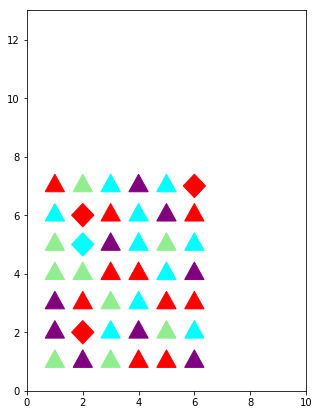

In [126]:
pic = s_before

fig, ax = plt.subplots(figsize=(5, 7))

ax.set_xlim((0, 10))
ax.set_ylim((0, 13))

circles = []

for ii in range(7):
    for jj in range(6):
        if (pic[ii, jj, 0] > 0):
            val = pic[ii, jj, 0]
            clr = "red"
        elif (pic[ii, jj, 1] > 0):
            val = pic[ii, jj, 1]
            clr = "lightgreen"
        elif (pic[ii, jj, 2] > 0):
            val = pic[ii, jj, 2]
            clr = "cyan"
        else:
            val = pic[ii, jj, 3]
            clr = "purple"
        
        if (val == 1):
            num_vertices = 3
        elif (val == 1.2):
            num_vertices = 4
        else:
            num_vertices = 5
            
        circles.append( mpatches.RegularPolygon((jj + 1, 7 - ii), numVertices=num_vertices, radius=0.4, color=clr) )

for circ in circles:
    ax.add_artist(circ)

In [1]:
GREAT_DICT = {1:1, 2:7, 3:19, 4:31, 5:43, 6:55, 7:2, 8:9, 9:21, 10:33, 11:45, 12:57, 13:3, 14:11, 15:23, 16:35, 17:47, 18:59, 
             19:4, 20:13, 21:25, 22:37, 23:49, 24:61, 25:5, 26:15, 27:27, 28:39, 29:51, 30:63, 31:6, 32:17, 33:29, 34:41,
             35:53, 36:65, 37:73, 38:81, 39:95, 40:109, 41:123, 42:74, 43:83, 44:97, 45:111, 46:125, 47:75, 48:85, 49:99,
             50:113, 51:127, 52:76, 53:87, 54:101, 55:115, 56:129, 57:77, 58:89, 59:103, 60:117, 61:131, 62:78, 63:91, 64:105,
             65:119, 66:133, 67:79, 68:93, 69:107, 70:121, 71:135}

In [26]:
#with open('replay_memory_4D_old.pickle', 'rb') as f:
#    replay_memory_old = pickle.load(f)

In [11]:
replay_memory_old_updated = []

for item in replay_memory_old:
    move71 = item[1]
    move142 = GREAT_DICT[move71]
    replay_memory_old_updated.append( (item[0], move142, item[2], item[3]) )

In [28]:
for item in replay_memory:
    replay_memory_old.append(item)

In [188]:
len(replay_memory)

11005

In [189]:
tmp = np.array([[1, 0, 2], [3, 3, 1], [0, 2, 0]])
tmp

array([[1, 0, 2],
       [3, 3, 1],
       [0, 2, 0]])

In [190]:
def myfunc(x):
    if (x > 0):
        x = 1 + (x - 1)*0.2
    
    return x

vfunc = np.vectorize(myfunc)

In [196]:
%%time
replay_memory_new = []
counter = 0

for item in replay_memory:
    tup = (vfunc(item[0]), item[1], item[2], vfunc(item[3]))

    replay_memory_new.append(tup)

Wall time: 1.23 s


In [97]:
predict_max_score(s_before, aero_cnn, number_of_moves)

(6.1822262, 116)